### This notebook contains some code for the practical project assignment.

### You aim to sample from the Funnel or Banana-shape distributions (see the definitions below).


### This notebook and scripts distributions.py, metrics.py, total_variation.py provides all required interface.


In [5]:
import numpy as np

import torch
from torch import nn
from torch import optim

import time
import tqdm

import tkinter
import pickle

from IPython.display import clear_output

import sys
sys.path.append('..')

import ot
import jax
import gc

from distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)

from metrics import ESS, acl_spectrum
from total_variation import (
    average_total_variation,
)

In [6]:
!pip install pyro-ppl easydict pot flax mlpaper
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Some utils that you may find useful

In [9]:
def plot_learned_density(
    flow,
    proposal,
    fig=None,
    device="cpu",
    xlim=[-1, 1],
    ylim=[-1, 1],
    rest=0.0,
):
    if fig is None:
        fig = plt.figure()
    n_pts = 200
    z = proposal.sample((n_pts**2,))
    x = np.linspace(*xlim, n_pts)
    y = np.linspace(*ylim, n_pts)
    xx, yy = np.meshgrid(x, y)
    zz = np.stack([xx, yy], -1)
    z[:, :2] = torch.FloatTensor(zz).view(-1, 2).to(device)
    z[:, 2:] = torch.FloatTensor([rest] * n_pts**2)[:, None]

    inv, minus_log_jac = flow.inverse(z)
    minus_log_jac = minus_log_jac.reshape(n_pts, n_pts)
    inv = inv.reshape(n_pts, n_pts, -1)
    vals = (proposal(inv) + minus_log_jac).exp().detach()

    im = plt.contourf(xx, yy, vals.reshape(n_pts, n_pts), cmap="GnBu")
    fig.colorbar(im)
    return fig

def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 50
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [10]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.0, colors=None):
    axs_names = ["Sliced TV", "ESS", "EMD ratio"]  # (on scaled data)']
    ncols = len(axs_names)

    figs = []
    axs = []
    for _ in range(ncols):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        figs.append(fig)
        axs.append(ax)

    mala_emd = metrics['MALA']['emd']
    
    for (name, res), color in zip(metrics.items(), colors):
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res["tv_mean"]
        axs[0].plot(ndims, arr, label=name, marker="o", color=color)

        axs[0].fill_between(
            ndims,
            res["tv_mean"] - 1.96 * res["tv_conf_sigma"],
            res["tv_mean"] + 1.96 * res["tv_conf_sigma"],
            alpha=0.2,
        )

        arr = res["ess"]
        axs[1].plot(ndims, arr, label=name, marker="o", color=color)

        if name != 'MALA':
            arr = mala_emd / res["emd"]
            axs[2].plot(ndims, arr, label=name, marker="o", color=color)
        #axs[2].set_yscale("log")

    for ax, fig, name in zip(axs, figs, axs_names):
        ax.grid()
        ax.set_title(name.split(' ')[0])
        ax.set_xlabel("dim")
        if name == "EMD ratio":
            ax.legend()

        fig.tight_layout()

        if savepath is not None:
            fig.savefig(Path(savepath, f"{name}.pdf"))

See below some code utils to run and generate ground-truth samples from the Funnel distribution.

$f(x_1, x_2, \cdots, x_d) = \left[\prod\limits_{i=2}^{d} \mathcal{N}(x_i \mid 0, e^{x_1 / 2}) \right] \times \mathcal{N}(x_1 \mid 0, a)$

“Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

Next example: $d$-dimensional Funnel distribution. Note that it allows for the reparametrisation, that allows for exact sampling. The  corresponding density function:
$$
p_{f}(x) = \operatorname{Z}^{-1} \exp\left(- x_1^2/2a^2 - (1/2) e^{-x_1} \sum\nolimits_{i=1}^{d-1}\{x_i^2 + x_1\}\right)\,, \quad d \geq 2,
$$
Note that we have a doule exponent in the density...

In [11]:
dist = "Funnel"
device = "cpu"
dim = 100
dist_class = "Funnel"
a = 2.0
b = 0.5
target = Funnel(
                dim=dim,
                device=device,
                a = a,
                b = b
                #**dist_params.dict,
)

In [12]:
#method_metric_dict = defaultdict(lambda: defaultdict(list))

### Generate ground-truth samples

In [13]:
N_samples = 1*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
True_samples[:,0] *= a 
for k in range(1,dim):
    True_samples[:,k] *= np.exp(True_samples[:,0]/2) 

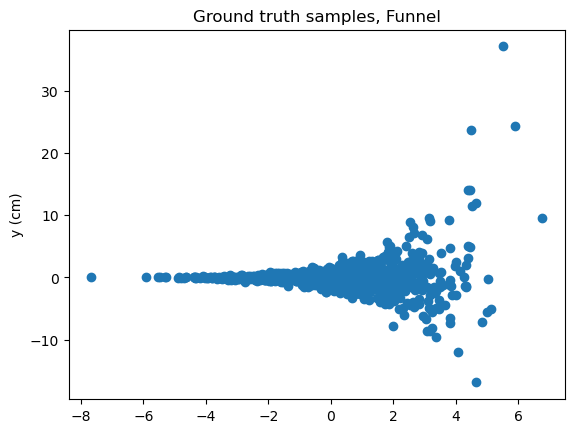

In [14]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1])
ax.set_title('Ground truth samples, Funnel')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

Below we show how to evaluate samples, obtained with some MCMC method:

In [15]:
N_samples = 1*10**3
np.random.seed(45)
True_samples_new = np.random.randn(N_samples,dim)
True_samples_new[:,0] *= a 
for k in range(1,dim):
    True_samples_new[:,k] *= np.exp(True_samples[:,0]/2) 
True_samples_new = np.expand_dims(True_samples_new,axis=1)
print(True_samples_new.shape)

(1000, 1, 100)


In [16]:
metrics = compute_metrics(
                    True_samples, #note that True_samples and True_samples_new have different shapes, artefact of the code...
                    True_samples_new,
                    name="Some baseline",
                    trunc_chain_len=0,
                    ess_rar=1,
)

(1000, 100)
(1000, 1, 100)


  0%|          | 0/50 [00:00<?, ?it/s]

====Some baseline====
TV distance. Mean: 0.058, Std: 0.014. 
ESS: 0.494 
EMD: 1104.371


Next potential - Banana-shape distribution. It has somehow simpler geometry, compared to the Funnel. The density function:
$$
p_{b}(x) = Z^{-1} \exp\left(- \sum\nolimits_{i=1}^{d/2}\bigl\{x_{2i}^2/2a^2 - (x_{2i-1} - bx_{2i}^{2} + a^2 b)^{2}/2 \bigr\}\right)\,, \quad d = 2k, k \in \mathbb{N}
$$

In [20]:
dist = "banana"
dim = 100
sigma_banana = 5.0
b_banana = 0.02

target_b = Banana(
                dim=dim,
                device=device,
                b = b_banana,
                sigma = sigma_banana,
                #b = b
                #**dist_params.dict,
)

In [23]:
N_samples = 2*10**3
np.random.seed(42)
True_samples_b = np.random.randn(N_samples,dim)
for i in range(dim):
    if i % 2 == 0:
        True_samples_b[:,i] *= sigma_banana
    else:
        True_samples_b[:,i] += b_banana*True_samples_b[:,i-1]**2 - (sigma_banana**2)*b_banana

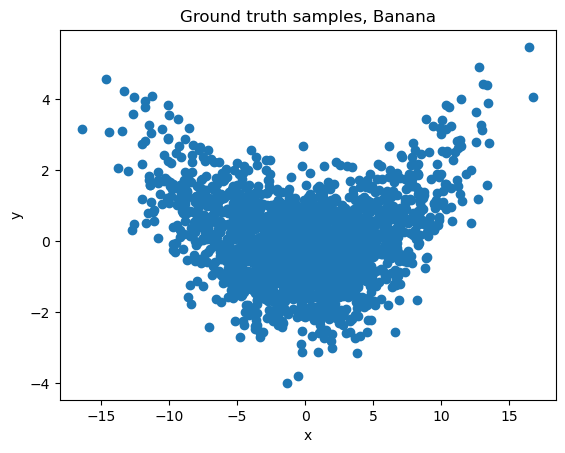

In [24]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples_b[:,2],True_samples_b[:,3])
ax.set_title('Ground truth samples, Banana')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Objectives

Sample from Banana and Funnel distributions with parameters specified above. Consider dimension $d = 100$. To get 100% of points for the task, you should beat the following metrics baselines with one of the MCMC methods:

Banana: Sliced TV = 0.05; Funnel: Sliced TV = 0.1

To get 70% of points, the baselines metrics are the following:

Banana: Sliced TV = 0.1; Funnel: Sliced TV = 0.3;

The evaluation procedure of your algorithm is the following:
1. Generate $1000$ of ground-truth samples with exact reparametrisation above;
2. Generate $50$ independent trajectories with your MCMC algorithm. Each trajectory should be of length at least $1000$ (it can be longer - then remove the first part as a burn-in;
3. Compute sliced TV metrics with the script above and average the result over independent trajectories;